In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

import numpy as np

import sys

In [3]:
#sys.path.append("../../")
import os
os.chdir("../../")

In [4]:
import logging

In [5]:
logger = logging.getLogger()

In [6]:
logger.setLevel(logging.INFO)

In [7]:
handler = logging.StreamHandler(sys.stdout)

In [8]:
logger.addHandler(handler)

#  load data

In [9]:
from benchdata.dblp_scholar_citations import DblpGoogleScholarCitationsData

In [37]:
data = DblpGoogleScholarCitationsData()

In [39]:
data.load()

In [40]:
data.default_fillna()

In [13]:
import fastText

In [14]:
from zipfile import ZipFile

In [16]:
fast_text_model_path = "data/pretrained/wiki-news-300d-1M-subword.bin"

In [17]:
model = fastText.load_model(fast_text_model_path)

In [18]:
from feature import pipelines

In [19]:
from models import scdv

In [17]:
data.KEY_COLUMN_PAIRS

[{'dblp': 'title', 'scholar': 'title'},
 {'dblp': 'authors', 'scholar': 'authors'},
 {'dblp': 'venue', 'scholar': 'venue'},
 {'dblp': 'year', 'scholar': 'year'}]

remove year, to check the  text features 

In [13]:
key_columns = [list(pair_dict.values()) for pair_dict in data.KEY_COLUMN_PAIRS[:-1]]

# train scdv

In [22]:
pipeline_func = lambda : pipelines.ConcatPipeline([("scdv", scdv.Scdv(word_emb_func=model.get_word_vector, n_components=10, sparse_threshold_p=0.04, verbose=2))])

In [23]:
pipeline_func_map_list = [pipeline_func for i in range(len(key_columns))]

In [24]:
extractor = pipelines.KeyColumnFeatureExtractor(key_column_correspondences=key_columns, pipeline_func_map_list=pipeline_func_map_list,  
                                                pipeline_save_dir="../result")

In [25]:
extractor.fit([data.dblp_df, data.scholar_df])

extracting features from ['title', 'title']
creating dictionary and computing idf...
clustering in-vocabulary words (size: 46590) ...
Initialization 0
  Iteration 0	 time lapse 9.39965s	 ll change inf
  Iteration 10	 time lapse 54.36003s	 ll change 0.05381
  Iteration 20	 time lapse 54.21361s	 ll change 0.00938
  Iteration 30	 time lapse 54.21595s	 ll change 0.00745
  Iteration 40	 time lapse 54.29864s	 ll change 0.00281
  Iteration 50	 time lapse 54.55032s	 ll change 0.00245
Initialization converged: True	 time lapse 302.75540s	 ll 940.12874
getting word-topic_vectors...
computing threshold to make sparse...
fitting has finished!!
extracting features from ['authors', 'authors']
creating dictionary and computing idf...
clustering in-vocabulary words (size: 49260) ...
Initialization 0
  Iteration 0	 time lapse 10.52038s	 ll change inf
  Iteration 10	 time lapse 50.38341s	 ll change 0.04977
  Iteration 20	 time lapse 50.76849s	 ll change 0.00969
  Iteration 30	 time lapse 50.63509s	 ll c

In [33]:
feature_matrixs = extractor.transform([data.dblp_df, data.scholar_df]) 

In [17]:
import scipy as sp

In [18]:
import scipy.sparse as sparse

In [19]:
from pathlib import Path

# save features

In [31]:
Path("result/citations").mkdir(parents=True, exist_ok=True)

In [34]:
data_names = ["dblp", "scholar"] 
for i, feature_set in enumerate(feature_matrixs):
    for j, feature in enumerate(feature_set):
        sp.sparse.save_npz("../result/{}_{}_scdv.npz".format(data_names[i], key_columns[j][i]), feature)

In [35]:
feature_matrixs = [sp.sparse.hstack(feature_matrix).tocsr() for feature_matrix in feature_matrixs]

In [36]:
!ls ../result

authors_authors_concat_model.pickle  scholar_title_scdv.npz
dblp_authors_scdv.npz		     scholar_venue_scdv.npz
dblp_title_scdv.npz		     title_title_concat_model.pickle
dblp_venue_scdv.npz		     venue_venue_concat_model.pickle
scholar_authors_scdv.npz


In [ ]:
del scdv

In [ ]:
del extractor

# check cosine similarity of same entity

In [45]:
index_pair = data.get_perfect_match_index(True)

In [38]:
index_pair[:3]

array([[ 1909, 24847],
       [ 2080, 44932],
       [ 2509,  1509]])

In [15]:
data_names = ["dblp", "scholar"]

In [20]:
feature_matrixs = [[sparse.load_npz("../result/{}_{}_scdv.npz".format(data_name, key_columns[j][i])) for j in range(len(key_columns))] for 
                   i, data_name in enumerate(data_names)]

In [21]:
from scipy.spatial.distance import cosine

In [30]:
feature_matrixs = [sp.sparse.hstack(feature_matrix).tocsr() for feature_matrix in feature_matrixs]

In [23]:
feature_matrixs[0].shape

(2616, 9000)

In [24]:
feature_matrixs[1].shape

(64263, 9000)

In [25]:
def distance_between_entity(row):
    return cosine(feature_matrixs[0][row[0]].todense(), feature_matrixs[1][row[1]].todense())

In [28]:
match_cosine_similariies = np.apply_along_axis(arr=index_pair, func1d=distance_between_entity, axis=1)

In [29]:
match_cosine_similariies[:10]

array([0.19229697, 0.17693594, 0.35879698, 0.45377624, 0.03961731,
       0.        , 0.40684512, 0.46699201, 0.67415838, 0.67268337])

In [48]:
import itertools

In [49]:
import random

In [51]:
all_pair_nums = data.dblp_df.shape[0] * data.scholar_df.shape[0] 

In [52]:
all_pair_nums

168112008

There are too many unmatched pairs. Therefore, undersample (0nly 0.1%)

In [54]:
unmatch_sampled_cosine_similarities = [cosine(feature_matrixs[0][i].todense(), feature_matrixs[1][j].todense()) for i, j in itertools.product(range(data.dblp_df.shape[0]), range(data.scholar_df.shape[0]))
                                if (not np.any(np.where((index_pair[:, 0] == i) & (index_pair[:, 1] == j)))) and random.randrange(0, 1000) == 0
                              ]

In [55]:
unmatch_sampled_cosine_similarities = np.vstack(unmatch_sampled_cosine_similarities)

In [56]:
unmatch_sampled_cosine_similarities.shape

(168174, 1)

In [57]:
import seaborn as sns

In [58]:
import matplotlib.pyplot as plt

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


([array([1.9440091 , 1.71164437, 1.85564505, 1.5103707 , 0.91473155,
         0.52200244, 0.21436464, 0.06218211, 0.01472734, 0.        ]),
  array([0.00000000e+00, 3.12165161e-04, 9.83320258e-03, 1.20547780e-01,
         6.33643250e-01, 1.72944702e+00, 2.82181698e+00, 2.54071225e+00,
         8.93156554e-01, 2.08110108e-04])],
 array([0.        , 0.11428993, 0.22857986, 0.34286979, 0.45715972,
        0.57144965, 0.68573958, 0.8000295 , 0.91431943, 1.02860936,
        1.14289929]),
 <a list of 2 Lists of Patches objects>)

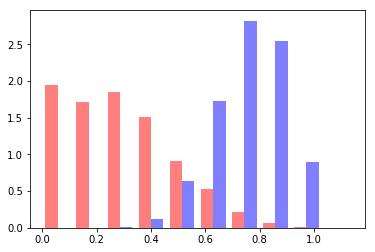

In [59]:
plt.hist([match_cosine_similariies, unmatch_sampled_cosine_similarities], color=['r','b'], alpha=0.5, normed=True)

Even at 1.0, there are some matching entities. 

In [68]:
del match_cosine_similariies

In [69]:
del unmatch_sampled_cosine_similarities

# k-nn

In [25]:
del data

In [24]:
from sklearn.neighbors import NearestNeighbors

In [23]:
import numpy as np

In [22]:
from feature import pipelines

In [27]:
from sklearn.decomposition import TruncatedSVD

In [28]:
svd_pipelines = pipelines.ConcatPipeline([("svd", TruncatedSVD(n_components=100))])

In [31]:
compress_feature = svd_pipelines.fit_transform(feature_matrixs)

In [32]:
knn_pipeline = pipelines.ConcatPipeline([("knn", NearestNeighbors(n_neighbors=30, algorithm='brute'))])

In [33]:
knn_pipeline.fit(compress_feature)

ConcatPipeline(memory=None,
        steps=[('knn', NearestNeighbors(algorithm='brute', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=30, p=2, radius=1.0))])

In [34]:
knn = knn_pipeline.steps[0][1]

In [35]:
del feature_matrixs

In [36]:
distances, indices = knn.kneighbors(compress_feature[0])

In [41]:
dblp_size = data.dblp_df.shape[0]

In [42]:
nn_offsets = np.ones((30)) * dblp_size

In [43]:
def in_neighbor(row):
    nns = indices[row[0]]
    return np.isin(row[1], nns - nn_offsets)

In [46]:
in_knns = np.apply_along_axis(arr=index_pair, func1d=in_neighbor, axis=1)

In [47]:
## ratio of the neghbors including the matched entity
in_knns.sum() / in_knns.shape[0]

0.31569104170562934

knn with Scdv features compressed by TruncatedSVD cannot find most of the correct neighbors (= matched entities) for each instance.  
It is thought there are 2 main reasons.
1. too samll samples to learn high-dimensional scdv. (number of scdv dimension >> number of samples) 
2. The nonlinearity in the entity matching task cause the difficulty for knn.  